In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline
from scipy.misc import imread, imsave, imresize
from scipy import ndimage
import os
import pickle
import re
from skimage import draw, data
import copy
import PIL.Image as Image
import cv2
from sklearn.cluster import KMeans
import numba

In [2]:
def get_image(path):
    #获取图片
    img=cv2.imread(path)
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    return img, gray

def Gaussian_Blur(gray):
    # 高斯去噪
    blurred = cv2.GaussianBlur(gray, (9, 9),0)

    return blurred

def Sobel_gradient(blurred):
    # 索比尔算子来计算x、y方向梯度
    gradX = cv2.Sobel(blurred, ddepth=cv2.CV_32F, dx=1, dy=0)
    gradY = cv2.Sobel(blurred, ddepth=cv2.CV_32F, dx=0, dy=1)

    gradient = cv2.subtract(gradX, gradY)
    gradient = cv2.convertScaleAbs(gradient)

    return gradX, gradY, gradient

def Thresh_and_blur(gradient):

    blurred = cv2.GaussianBlur(gradient, (9, 9),0)
    (_, thresh) = cv2.threshold(blurred, 90, 255, cv2.THRESH_BINARY)

    return thresh

def image_morphology(thresh):
    # 建立一个椭圆核函数
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (25, 25))
    # 执行图像形态学, 细节直接查文档，很简单
    closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    closed = cv2.erode(closed, None, iterations=4)
    closed = cv2.dilate(closed, None, iterations=4)

    return closed

def findcnts_and_box_point(closed):
    # 这里opencv3返回的是三个参数
    (_, cnts, _) = cv2.findContours(closed.copy(), 
        cv2.RETR_LIST, 
        cv2.CHAIN_APPROX_SIMPLE)
    c = sorted(cnts, key=cv2.contourArea, reverse=True)[0]
    # compute the rotated bounding box of the largest contour
    rect = cv2.minAreaRect(c)
    box = np.int0(cv2.boxPoints(rect))

    return box

def drawcnts_and_cut(original_img, box):
    # 因为这个函数有极强的破坏性，所有需要在img.copy()上画
    # draw a bounding box arounded the detected barcode and display the image
    draw_img = cv2.drawContours(original_img.copy(), [box], -1, (0, 0, 255), 3)

    Xs = [i[0] for i in box]
    Ys = [i[1] for i in box]
    x1 = min(Xs)
    x2 = max(Xs)
    y1 = min(Ys)
    y2 = max(Ys)
    hight = y2 - y1
    width = x2 - x1
    crop_img = original_img[y1:y1+hight, x1:x1+width]

    return draw_img, crop_img

def count_nonzero_rate(img):
    count = np.count_nonzero(img)
    return count / (img.shape[0]*img.shape[1])

def fill_depth(depth, h=3, w=5):
    weight = np.ndarray((2*h,2*w))
    height, width = depth.shape[:2]
    for i in range(2*h):
        for j in range(2*w):
            if i==h and j==w: continue
            weight[i,j] = 1/np.sqrt((i-h)**2 + (j-w)**2)
    weight[h,w] = 0
    #print(weight)
    for i in range(h, height-h):     #
        for j in range(w, width-w):
            if depth[i, j] == 0:
                patch = depth[i-h:i+h, j-w:j+w]
                if np.sum(patch) == 0: continue
                depth[i, j] = patch[patch != 0].mean()
#                 mask = patch > 0
#                 mask_weight = weight * mask
#                 depth[i,j] = np.sum(patch * mask_weight) / np.sum(mask_weight)
              
    for i in range(h):
        depth[i] = depth[h]
        depth[-i-1] = depth[-h-1]
    for j in range(w):
        depth[:,j] = depth[:,w]
        depth[:,-j-1] = depth[:,-h-1]
        
    return depth

def kmeans(img, clusters=5):
    data = []
    h, w = img.shape[0:2] #活的图片大小
    print((h,w))
    for i in range(h):
        for j in range(w):  #将每个像素点RGB颜色处理到0-1范围内并存放data
            data.append(img[i,j])
    label = KMeans(n_clusters=5).fit_predict(data)  #聚类中心的个数为3
    label = label.reshape([h,w])    #聚类获得每个像素所属的类别
    return label#以矩阵型式返回data，图片大小

In [3]:
@numba.jit(nopython=True)   
def apply_nadaraya_watson( _inputImage, _kernelSize = 7, _alpha=1 ):

    dst = np.zeros( shape=_inputImage.shape )
    uv_lut = np.zeros( shape=(_kernelSize, _kernelSize) )

    halfKernel = int(np.floor(_kernelSize/2))

    mask = _inputImage > 0

    kernelRange = range(-halfKernel,halfKernel+1, 1)

    for k_v in kernelRange: 
        for k_u in kernelRange:
            uv_lut[k_v+halfKernel, k_u+halfKernel] = np.sqrt(k_v**2 + k_u**2)

    imgHeight = _inputImage.shape[0]
    imgWidth = _inputImage.shape[1]

    #nbprint "Performing nadaraya watson on image with size ({},{})".format(imgHeight,imgWidth)

    for v in range(imgHeight):
        for u in range(imgWidth):
            nw_numerator = 0
            nw_denominator = 0
            for k_v in kernelRange: 
                for k_u in kernelRange:
                    if v+k_v < imgHeight and v+k_v > 0 and u+k_u < imgWidth and u+k_u > 0:
                        nw_numerator+= np.exp(-_alpha*uv_lut[k_v+halfKernel, k_u+halfKernel]) * _inputImage[v+k_v, u+k_u]
                        nw_denominator+= np.exp(-_alpha*uv_lut[k_v+halfKernel, k_u+halfKernel]) * mask[v+k_v, u+k_u]
            if nw_denominator != 0:
                dst[v,u] = nw_numerator / nw_denominator
            else:
                dst[v,u] = 0 # nw_numerator / nw_denominator

    return dst

# nearest neighbor interpolation
@numba.jit(nopython=True)   
def apply_nearest_neighbor( _inputImage, _maxRadius=10 ):

    #destination image
    dst = np.zeros( shape=_inputImage.shape )
    imgHeight = _inputImage.shape[0]
    imgWidth = _inputImage.shape[1]

    #nbprint "Performing nadaraya watson on image with size ({},{})".format(imgHeight,imgWidth)

    for v in range(imgHeight):
        for u in range(imgWidth):
            searchRadius=1
            not_found = True
            nn_values = []
            while not_found:
                for k_v in range(-searchRadius,searchRadius,1): 
                    for k_u in range(-searchRadius,searchRadius,1):
                        if v+k_v < imgHeight and v+k_v > 0 and u+k_u < imgWidth and u+k_u > 0:
                            if _inputImage[v+k_v,u+k_u] != 0:
                                nn_values.append(_inputImage[v+k_v,u+k_u])
                                not_found=False
                searchRadius=searchRadius+1
                if not_found and searchRadius==_maxRadius-1:
                    nn_values.append(0)
                    not_found=False

            if len(nn_values):
                dst[v,u] = np.random.choice(np.array(nn_values))
            else:
                dst[v,u] = 0#np.random.choice(np.array(nn_values))

    return dst

In [4]:
rgb_dir = 'D:/剪裁好的数据/2d_finish/'
rgb_filename_list=os.listdir(rgb_dir)
rgb_path = [os.path.join(rgb_dir, name) for name in rgb_filename_list]

ir_dir = 'D:/剪裁好的数据/ir_finish/'
ir_filename_list=os.listdir(ir_dir)
ir_path = [os.path.join(ir_dir, name) for name in ir_filename_list]

depth_dir = 'D:/剪裁好的数据/depth_finish/'
depth_filename_list=os.listdir(depth_dir)
depth_path = [os.path.join(depth_dir, name) for name in depth_filename_list]

In [5]:
print(len(depth_path))
print(depth_path[100])

435
D:/剪裁好的数据/depth_finish/depth_00100577.png


# 测试

In [10]:
index = 100
depth = imread(depth_path[index])
depth = depth / 255
rgb = imread(rgb_path[index])
ir = imread(ir_path[index])
print(depth_path[100])

D:/剪裁好的数据/depth_finish/depth_00100577.png


In [11]:
np.max(depth)

60.235294117647058

In [18]:
#clus = kmeans(rgb, clusters=3)

In [12]:
#depth_point = fill_depth(depth.copy(), w=7, h=5)
depth_point1 = apply_nadaraya_watson(depth)
depth_point2 = apply_nearest_neighbor(depth)
depth_point11 = fill_depth(depth_point1.copy(), w=7, h=5)
depth_point22 = fill_depth(depth_point2.copy(), w=7, h=5)

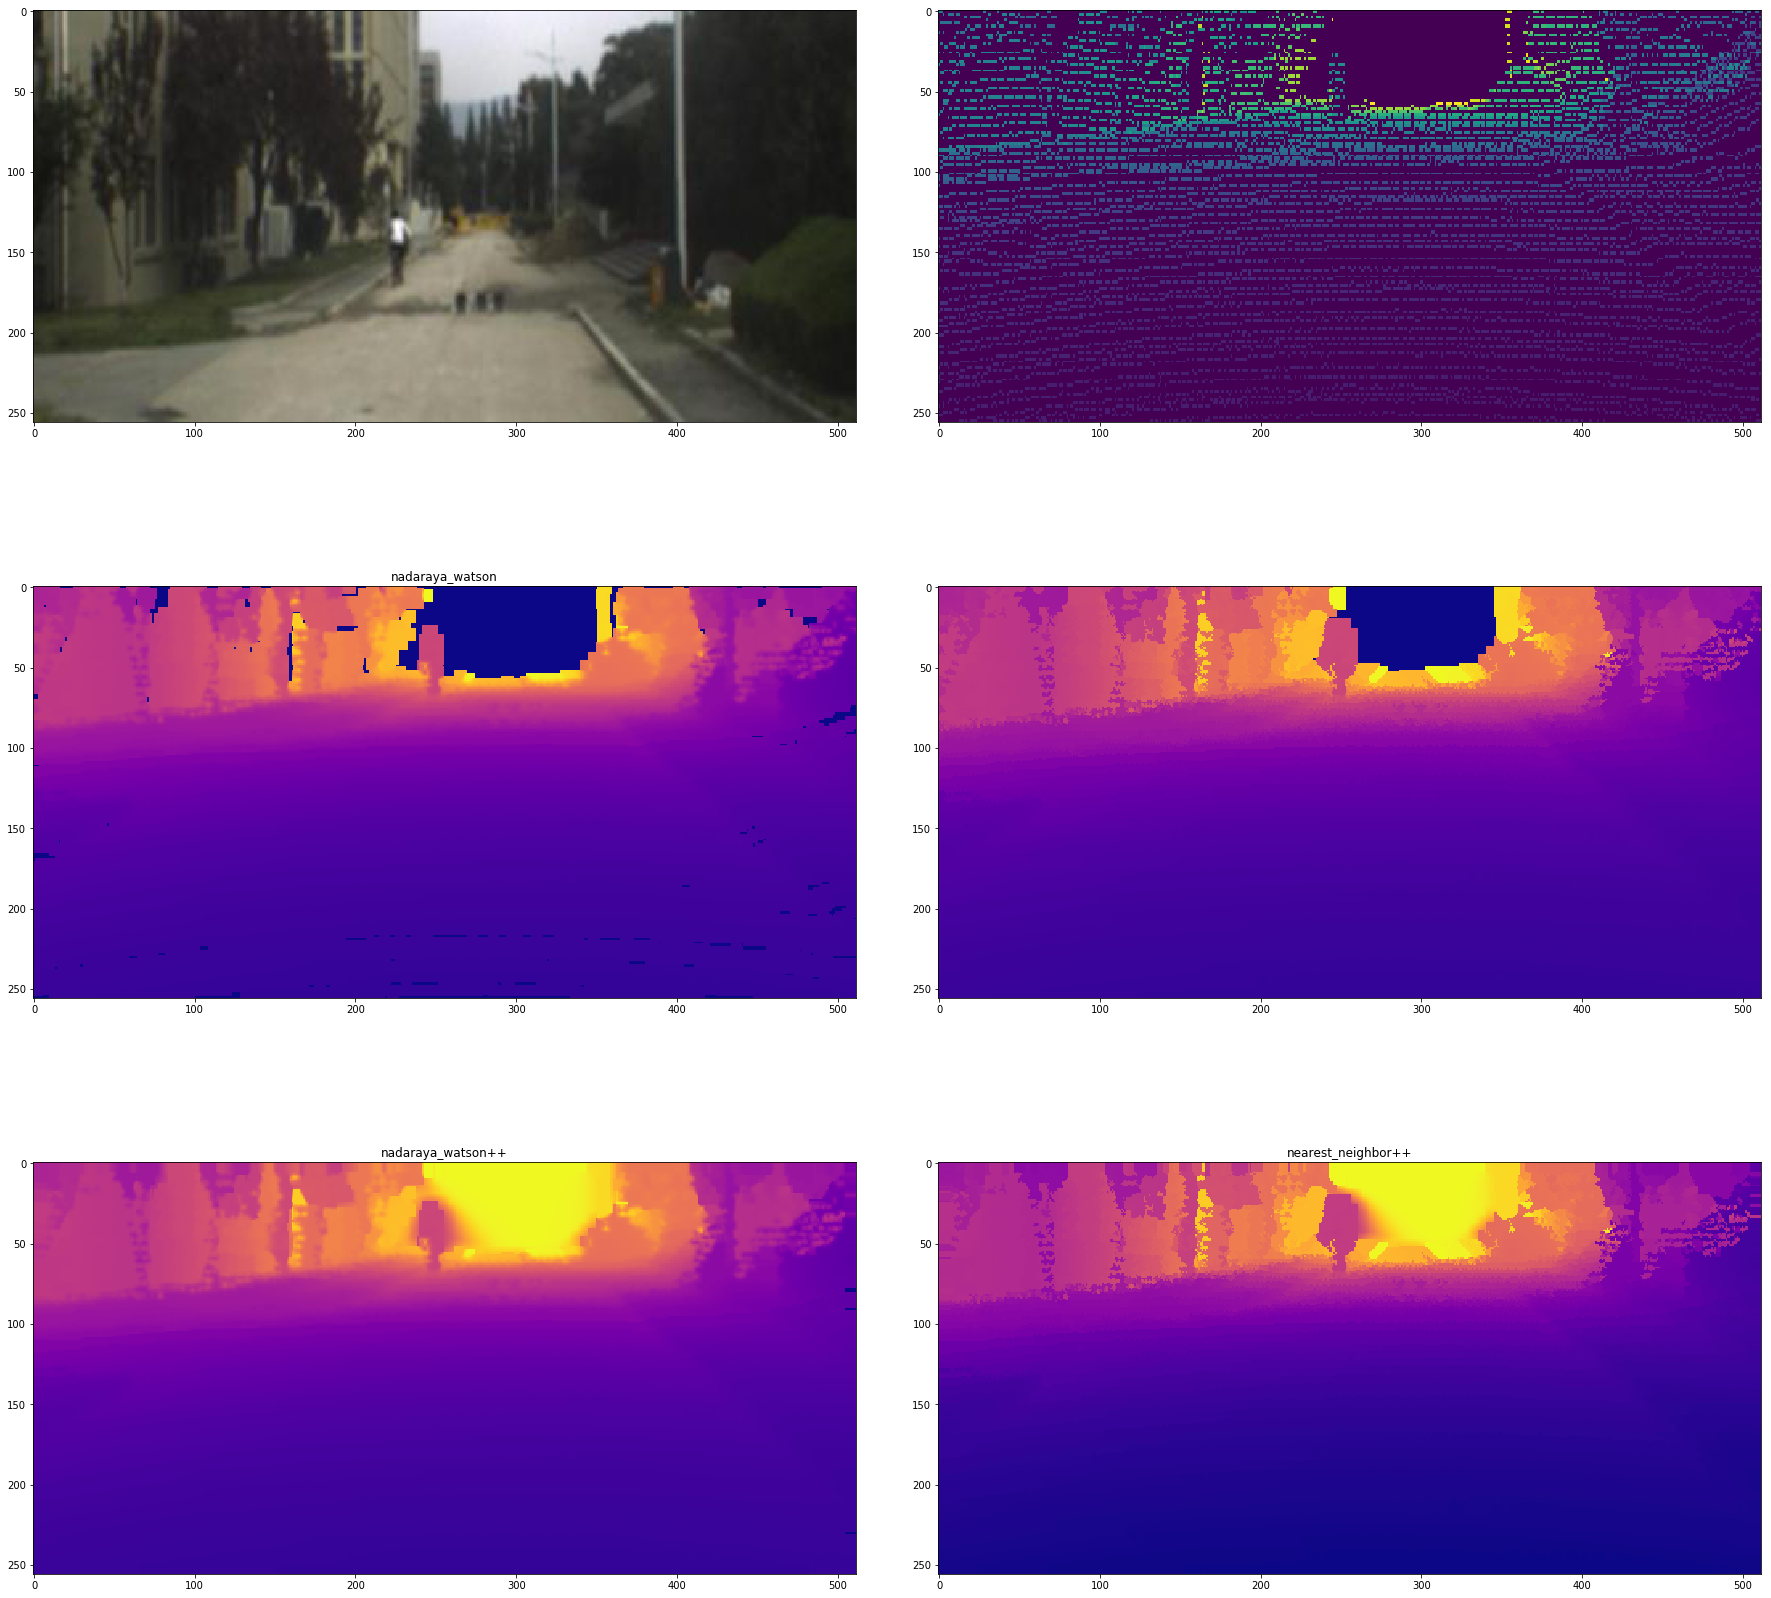

In [15]:
plt.figure(figsize=(60,40))
plt.subplots_adjust(left=0.1, bottom=0.2, right=0.5, top=0.8, hspace=0.0, wspace=0.1)
plt.subplot(321)
plt.imshow(rgb)
plt.subplot(322)
plt.imshow(depth)
#plt.imsave('depth.png',depth)
plt.subplot(323)
plt.imshow(depth_point1, cmap='plasma')
plt.title('nadaraya_watson')
plt.subplot(324)
plt.imshow(depth_point2, cmap='plasma')
plt.imsave('depth_point2.png',depth_point2)
#plt.title('nearest_neighbor')
plt.subplot(325)
plt.imshow(depth_point11, cmap='plasma')
plt.title('nadaraya_watson++')
plt.subplot(326)
plt.imshow(depth_point22, cmap='plasma')
plt.title('nearest_neighbor++')
plt.show()

# 批量生成

In [6]:
def HANDLE(depth_path, save_depth_dir, index):   # overall handling 
    for i in range(index[0],index[1]):                 # index 表示图片范围
        depth_name = os.path.split(depth_path[i])[1]
        depth_name = depth_name.split('.')[0][-8:] + '.png'
        save_depth_name = os.path.join(save_depth_dir, 'depth_complete_' + depth_name)  # 'E:/.../crop_xxxxxxx.jpg'
        depth = imread(depth_path[i])
        depth = depth / 255
        percentage = (i-index[0])/(index[1]-index[0]-1) * 100   # 进度条
        print("Handle the %4dth depth: (%s)   %f%% " % (i, depth_name, percentage))
        
        depth_point = fill_depth(depth.copy(), w=7, h=5)
        depth_point = depth_point * 255
        depth_point.astype(int)
        depth_point = Image.fromarray(depth_point)
        depth_point = depth_point.convert('I')
        depth_point.save(save_depth_name)
    print('Done.')

In [7]:
depth_save_dir = 'D:/剪裁好的数据/depth_complete/seq01/'

In [9]:
HANDLE(depth_path, depth_save_dir, (90,102))

Handle the   90th depth: (00100525.png)   0.000000% 
Handle the   91th depth: (00100530.png)   9.090909% 
Handle the   92th depth: (00100536.png)   18.181818% 
Handle the   93th depth: (00100541.png)   27.272727% 
Handle the   94th depth: (00100546.png)   36.363636% 
Handle the   95th depth: (00100551.png)   45.454545% 
Handle the   96th depth: (00100557.png)   54.545455% 
Handle the   97th depth: (00100562.png)   63.636364% 
Handle the   98th depth: (00100567.png)   72.727273% 
Handle the   99th depth: (00100572.png)   81.818182% 
Handle the  100th depth: (00100577.png)   90.909091% 
Handle the  101th depth: (00100583.png)   100.000000% 
Done.


In [3]:
list(range(-1,1,1))

[-1, 0]